In [38]:
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import cartopy.feature

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')

shapefile_path = '/home/mpgetz/repos/bee_mapping/data/shapefiles/ne_110m_land/ne_110m_land.shp'
gdf = gpd.read_file(shapefile_path)

lakes_shapefile_path = 'data/shapefiles/ne_110m_lakes/ne_110m_lakes.shp'
lakes_gdf = gpd.read_file(lakes_shapefile_path)

# Define the bounding box
bbox = [-125, 35, -66, 54] # [minx, miny, maxx, maxy]

num_points_side = int(np.sqrt(1000))  # For approximately 1000 points
lons = np.linspace(bbox[0], bbox[2], num_points_side)
lats = np.linspace(bbox[1], bbox[3], num_points_side)

grid_points = [Point(lon, lat) for lat in lats for lon in lons]
grid_gdf = gpd.GeoDataFrame(geometry=grid_points)

land_points = grid_gdf[grid_gdf['geometry'].apply(lambda point: gdf.contains(point).any() and not lakes_gdf.contains(point).any())]
# Convert the points to a suitable format for your use
land_coordinates = [(point.y, point.x) for point in land_points['geometry']]

great_lakes = cfeature.NaturalEarthFeature(category='physical', name='lakes', scale='110m')


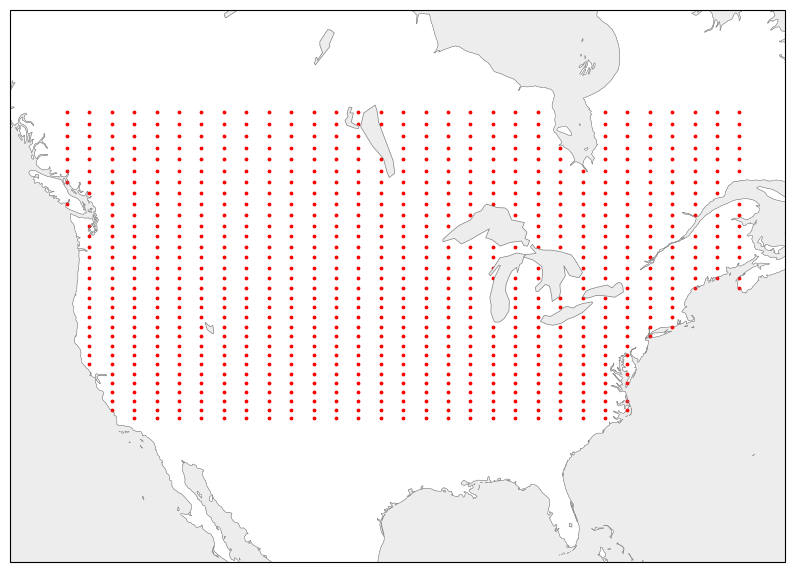

In [50]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np


# Create a plot with a Mercator projection
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})
ax.set_extent([-130, -62, 24, 54])  # Set the extent (longitude, longitude, latitude, latitude)


ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

# Plot the points
lats, lons = zip(*land_coordinates)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), marker='o', color='red', s=3)


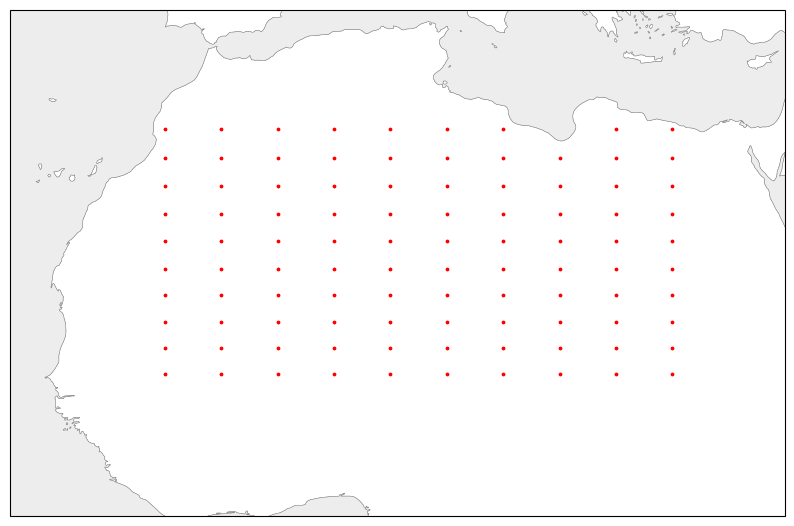

In [95]:
# Define the bounding box
bbox = [-9, 15, 27, 31] # [minx, miny, maxx, maxy]

num_points_side = int(np.sqrt(100))  
lons = np.linspace(bbox[0], bbox[2], num_points_side)
lats = np.linspace(bbox[1], bbox[3], num_points_side)

grid_points = [Point(lon, lat) for lat in lats for lon in lons]
sahara_gdf = gpd.GeoDataFrame(geometry=grid_points)

land_points = sahara_gdf[sahara_gdf['geometry'].apply(lambda point: gdf.contains(point).any() and not lakes_gdf.contains(point).any())]
# Convert the points to a suitable format for your use
sahara_coordinates = [(point.y, point.x) for point in land_points['geometry']]


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})
ax.set_extent([-20, 35, 5, 35])  # Set the extent (longitude, longitude, latitude, latitude)


ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

# Plot the points
lats, lons = zip(*sahara_coordinates)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), marker='o', color='red', s=3)


In [96]:
sahara_gdf['lon'] = sahara_gdf['geometry'].x
sahara_gdf['lat'] = sahara_gdf['geometry'].y

# Create a new DataFrame with just the 'lat' and 'lon' columns
lat_lon_df = sahara_gdf[['lat', 'lon']]

# Export to CSV
lat_lon_df.to_csv('sahara_points.csv', index=False)

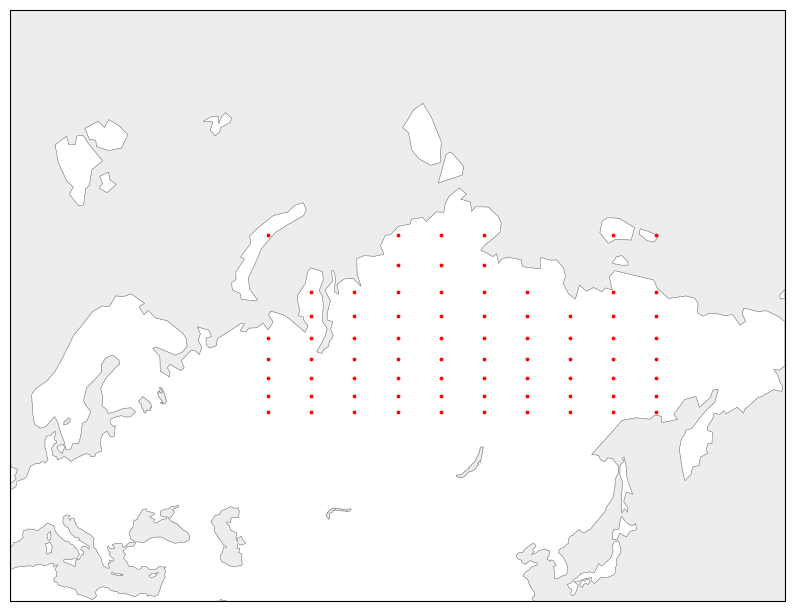

In [93]:
# Define the bounding box
bbox = [60, 60, 150, 77] # [minx, miny, maxx, maxy]

num_points_side = int(np.sqrt(100))  
lons = np.linspace(bbox[0], bbox[2], num_points_side)
lats = np.linspace(bbox[1], bbox[3], num_points_side)

grid_points = [Point(lon, lat) for lat in lats for lon in lons]
siberia_gdf = gpd.GeoDataFrame(geometry=grid_points)

land_points = siberia_gdf[siberia_gdf['geometry'].apply(lambda point: gdf.contains(point).any() and not lakes_gdf.contains(point).any())]
# Convert the points to a suitable format for your use
siberia_coordinates = [(point.y, point.x) for point in land_points['geometry']]


fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.Mercator()})
ax.set_extent([0, 180, 30, 75])  # Set the extent (longitude, longitude, latitude, latitude)


ax.add_feature(cfeature.LAND, facecolor='white', edgecolor='gray', linewidth=.5)
ax.add_feature(cfeature.COASTLINE, linewidth=.2, edgecolor='gray')
ax.add_feature(cfeature.OCEAN, facecolor='#ededed', linewidth=.1, zorder=1, edgecolor='gray')
ax.add_feature(great_lakes, facecolor='#ededed', linewidth=.5, edgecolor='gray')

# Plot the points
lats, lons = zip(*siberia_coordinates)
ax.scatter(lons, lats, transform=ccrs.PlateCarree(), marker='o', color='red', s=3)

In [94]:
siberia_gdf['lon'] = siberia_gdf['geometry'].x
siberia_gdf['lat'] = siberia_gdf['geometry'].y

# Create a new DataFrame with just the 'lat' and 'lon' columns
lat_lon_df = siberia_gdf[['lat', 'lon']]

# Export to CSV
lat_lon_df.to_csv('siberia_points.csv', index=False)

In [ ]:
import os
import rasterio
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

def get_value_from_array(lat, long, src, array):
    try:
        row, col = src.index(long, lat)
        return array[row, col]
    except Exception as e:
        print(f'Error at {lat}, {long}: {e}')
        return None

directory = '/home/mpgetz/repos/bee_mapping/data/wc2.1_30s_bio'
all_files = [f for f in os.listdir(directory) if f.endswith('.tif') and "wc2.1_30s_" in f]

print(all_files)

def process_file(file):
    column_name = file.split("wc2.1_30s_")[1].replace(".tif", "")
    file_path = os.path.join(directory, file)
    print(f'Processing: {column_name}\n')

    with rasterio.open(file_path) as src:
        array = src.read(1)  # Read the entire file into an array
        data_loc_date[column_name] = data_loc_date.apply(lambda row: get_value_from_array(row['lat'], row['lon'], src, array), axis=1)

# Assuming data_loc_date is your DataFrame with lat and lon
with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust max_workers based on your CPU
    executor.map(process_file, all_files)

data_loc_date.to_csv('test2.csv')